<a href="https://colab.research.google.com/github/mipypf/scej-mi/blob/develop/chapter12/scej_mi_chapter12_example_gp_shap_pdp_plotly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MI領域で最もオーソドックスかつ使用頻度の高いテーブルデータタスクを題材にして、デモデータを用いた解釈の実例を扱う

### 使用するデータセットの参考文献
- Tamura, R. et al. Materials informatics approach to understand aluminum alloys. Sci Technol Adv Mater 540–551 (2020) doi:10.1080/14686996.2020.1791676

### データセットのダウンロード
- https://www.tandfonline.com/doi/full/10.1080/14686996.2020.1791676#supplemental-material-section からtsta_a_1791676_sm7404.csvをダウンロード

### Google Colabの準備

##### 右上の「接続」をクリックし、ランタイムに接続

In [1]:
# Google Colabを利用する場合はTrue、そうでない場合はFalseとする
colab = True

In [2]:
# Google Colabのファイルをクリックし、tsta_a_1791676_sm7404.csvをドラッグ＆ドロップしてアップロード
if colab:
  INPUT_FILE_PATH = "./"
  OUTPUT_FILE_PATH = "./"
else:
  INPUT_FILE_PATH = "../input/"
  OUTPUT_FILE_PATH = "../output/"

##### ライブラリをインストール

In [3]:
! pip install japanize_matplotlib==1.1.3
! pip install adjustText==1.2.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 35.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=bdd083f9e8a412f5a58153350c5a6ac34507ad1273fb4d102060c09fa0f50b88
  Stored in directory: /root/.cache/pip/wheels/da/a1/71/b8faeb93276fed10edffcca20746f1ef6f8d9e071eee8425fc
Successfully built japanize_matplotlib


### ライブラリをインポート

In [57]:
import os
import warnings

warnings.filterwarnings("ignore")

import pickle

import japanize_matplotlib
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from adjustText import adjust_text
from pandas import json_normalize
import sklearn
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import PartialDependenceDisplay
import tqdm
import shap
import scipy
from scipy.stats import norm
import plotly
from plotly import express as px
import plotly.graph_objects as go

print("matplotlib:", matplotlib.__version__)
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("seaborn:", sns.__version__)
print("scikit-learn:", sklearn.__version__)
print("tqdm:", tqdm.__version__)
print("shap:", shap.__version__)
print("scipy:", scipy.__version__)
print("plotly:", plotly.__version__)

from tqdm.notebook import tqdm

matplotlib: 3.10.0
numpy: 2.0.2
pandas: 2.2.2
seaborn: 0.13.2
scikit-learn: 1.6.1
tqdm: 4.67.1
shap: 0.48.0
scipy: 1.15.3
plotly: 5.24.1


In [5]:
plt.rcParams["font.size"] = 20
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["axes.titlesize"] = 20

### ファイルのコンフィグ情報を定義

In [6]:
class CFG:
    input_dir = INPUT_FILE_PATH
    output_dir = OUTPUT_FILE_PATH
    random_seed = 42
    exp_no = "exp000"

### データの読み込み

In [7]:
# Google Colabの左部の「ファイル」アイコンをクリックし、tsta_a_1791676_sm7404.csvをドラッグ＆ドロップしてアップロード
data = pd.read_csv(f"{CFG.input_dir}/tsta_a_1791676_sm7404.csv")
data

,ID,X,Fe (wt%),Mn (wt%),Si (wt%),Al (wt%),Mg (wt%),Ti (wt%),Cu (wt%),Cr (wt%),Zn (wt%),2% proof stress (Mpa),Tensile strength (Mpa),Elongation (%)
0,A 6005A BE,1,0.18,0.25,0.70,97.88,0.55,0.05,0.15,0.15,0.10,100,170,15
1,A 6005A BE,4,0.18,0.25,0.70,97.88,0.55,0.05,0.15,0.15,0.10,90,180,15
2,A 6005A BE,5,0.18,0.25,0.70,97.88,0.55,0.05,0.15,0.15,0.10,215,260,9
3,A 6005A BE,6,0.18,0.25,0.70,97.88,0.55,0.05,0.15,0.15,0.10,225,270,8
4,A 6005C BE,1,0.18,0.25,0.65,97.83,0.60,0.05,0.18,0.15,0.13,107,176,16
5,A 6005C BE,5,0.18,0.25,0.65,97.83,0.60,0.05,0.18,0.15,0.13,175,225,8
6,A 6005C BE,6,0.18,0.25,0.65,97.83,0.60,0.05,0.18,0.15,0.13,235,265,8
7,A 6060 BE,4,0.20,0.05,0.45,98.63,0.48,0.05,0.05,0.03,0.08,60,120,14
8,A 6060 BE,5,0.20,0.05,0.45,98.63,0.48,0.05,0.05,0.03,0.08,120,160,6
9,A 6060 BE,6,0.20,0.05,0.45,98.63,0.48,0.05,0.05,0.03,0.08,150,190,8


### EDA

##### データの列名を確認

In [8]:
columns = data.columns
columns

Index(['ID', 'X', 'Fe (wt%)', 'Mn (wt%)', 'Si (wt%)', 'Al (wt%)', 'Mg (wt%)',
       'Ti (wt%)', 'Cu (wt%)', 'Cr (wt%)', 'Zn (wt%)', '2% proof stress (Mpa)',
       'Tensile strength (Mpa)', 'Elongation (%)'],
      dtype='object')

##### データの欠損を確認

In [9]:
data.isnull().sum()

,0
ID,0
X,0
Fe (wt%),0
Mn (wt%),0
Si (wt%),0
Al (wt%),0
Mg (wt%),0
Ti (wt%),0
Cu (wt%),0
Cr (wt%),0


##### IDごとに個数をカウント

In [10]:
data['ID'].value_counts()

,count
ID,
A 6005A BE,4
A 6463 S,4
A 6063 BD,4
A 6005C BE,3
A 6060 BE,3
A 6262 BD,3
A 6061 BD,2
A 6061 P,2
A 6082 P,2


##### IDごとのXの値を可視化

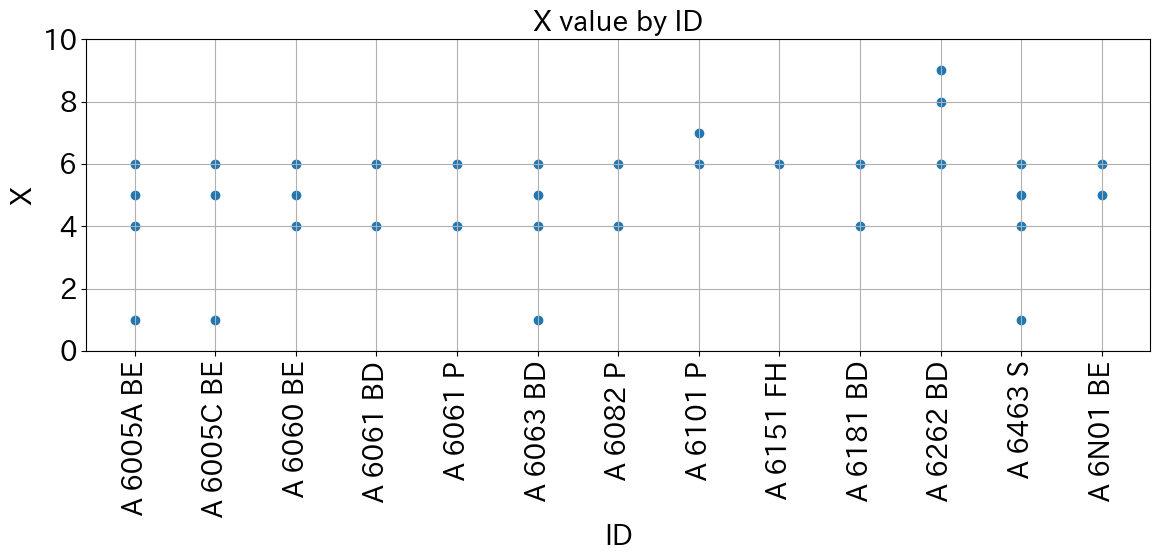

In [11]:
plt.figure(figsize=(12, 6))
plt.scatter(data["ID"], data["X"])
plt.xlabel("ID")
plt.ylabel("X")
plt.title("X value by ID")
plt.xticks(rotation=90)
plt.ylim(bottom=0)
plt.ylim(top=10)
plt.grid(True)
plt.tight_layout()
plt.show()

##### 2% proof stress (Mpa)のヒストグラムを作成

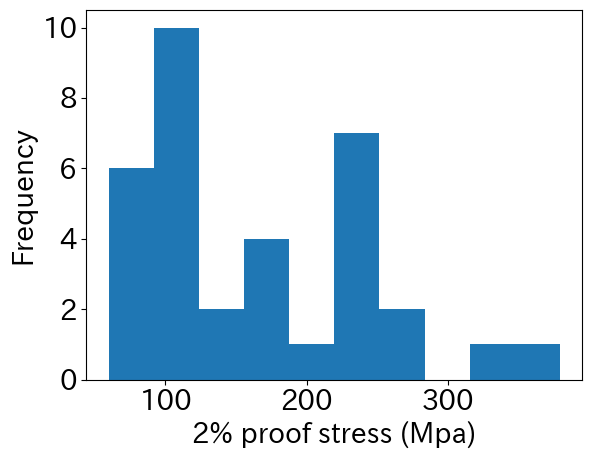

In [12]:
plt.hist(data["2% proof stress (Mpa)"])
plt.xlabel("2% proof stress (Mpa)")
plt.ylabel("Frequency")
plt.show()

### 使用する説明変数をリストとして定義

In [13]:
numeric_parameter_cols = [
    # 'ID',
    'X',
    'Fe (wt%)',
    'Mn (wt%)',
    'Si (wt%)',
    'Al (wt%)',
    'Mg (wt%)',
    'Ti (wt%)',
    'Cu (wt%)',
    'Cr (wt%)',
    'Zn (wt%)',
    # '2% proof stress (Mpa)',
    # 'Tensile strength (Mpa)',
    # 'Elongation (%)'
    ]

### 説明変数と目的変数の定義

In [14]:
train_X = data[numeric_parameter_cols]
objective_cols = ['2% proof stress (Mpa)']
train_Y = data[objective_cols]

### GaussianProcessRegressorを用いたLeave-one-outによる交差検証

0it [00:00, ?it/s]

Index([0], dtype='int64')
RMSE_train: 19.115307470200467
MAE_train: 15.735116036007673
R2_train: 0.9447928049860442
Index([1], dtype='int64')
RMSE_train: 14.728411270143704
MAE_train: 12.575616576477993
R2_train: 0.9670085110635067
Index([2], dtype='int64')
RMSE_train: 0.6350519682835866
MAE_train: 0.26117521824191064
R2_train: 0.9999395264075447
Index([3], dtype='int64')
RMSE_train: 22.961064505525833
MAE_train: 19.470034618803986
R2_train: 0.9205316817002367
Index([4], dtype='int64')
RMSE_train: 19.21175712469117
MAE_train: 15.50599338286564
R2_train: 0.9444580343109329
Index([5], dtype='int64')
RMSE_train: 23.04198070700828
MAE_train: 19.23324105509426
R2_train: 0.9212856454886356
Index([6], dtype='int64')
RMSE_train: 23.191862920077497
MAE_train: 19.62596824559822
R2_train: 0.9184231438894555
Index([7], dtype='int64')
RMSE_train: 22.784891598418053
MAE_train: 18.713449966617492
R2_train: 0.9189782623575474
Index([8], dtype='int64')
RMSE_train: 21.703329459581497
MAE_train: 18.26577

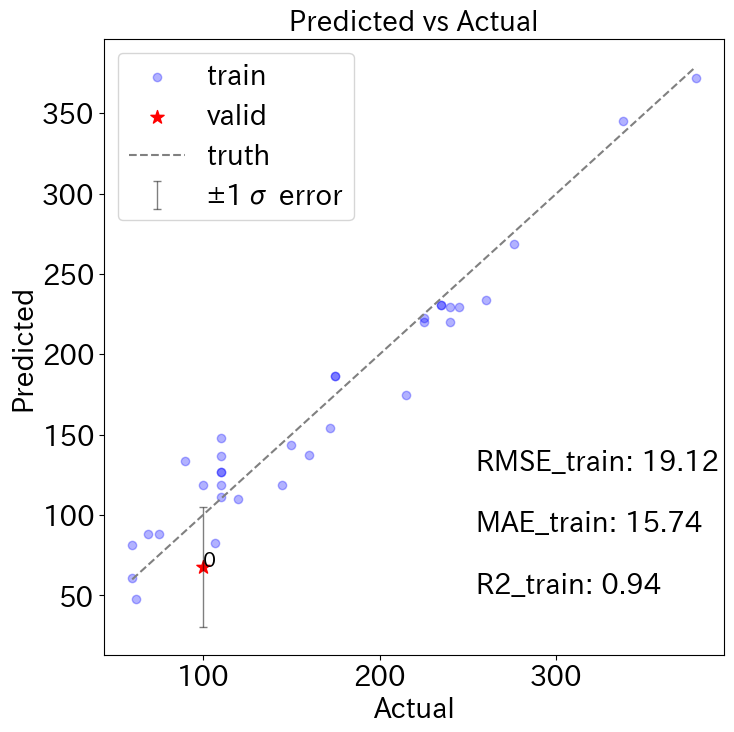

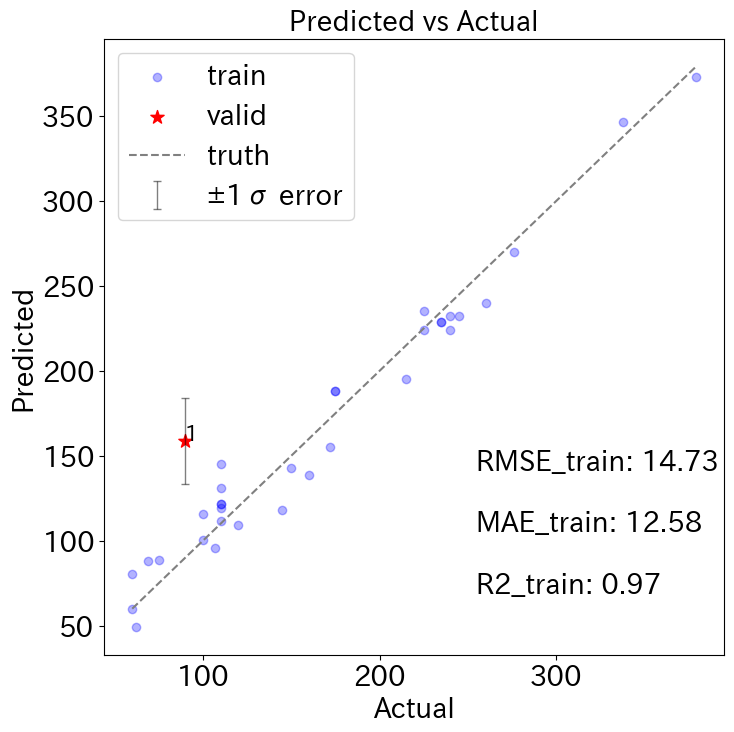

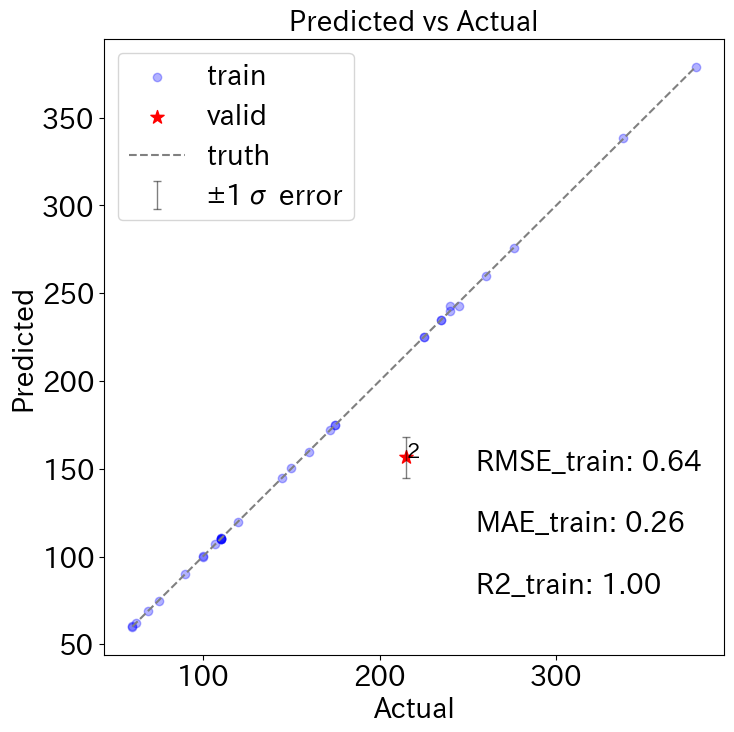

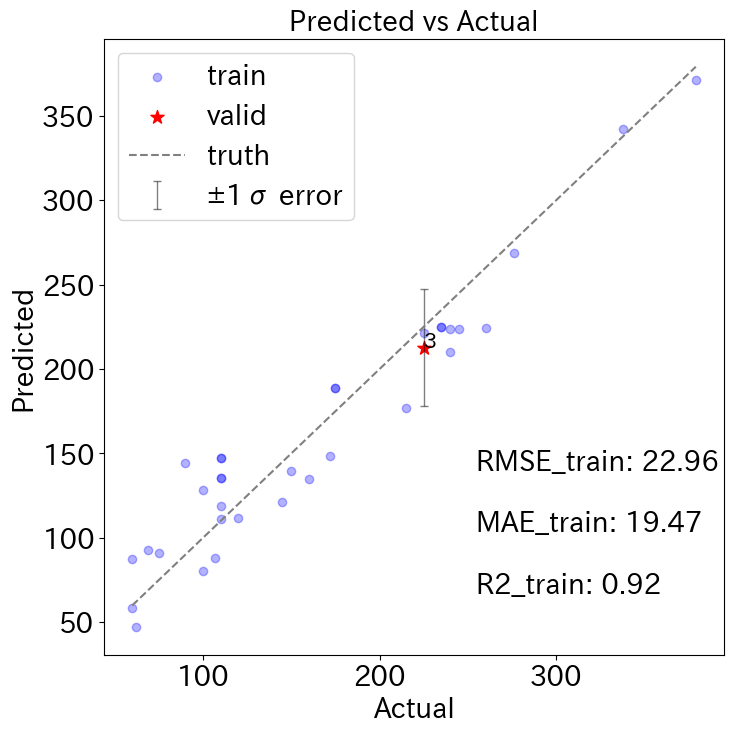

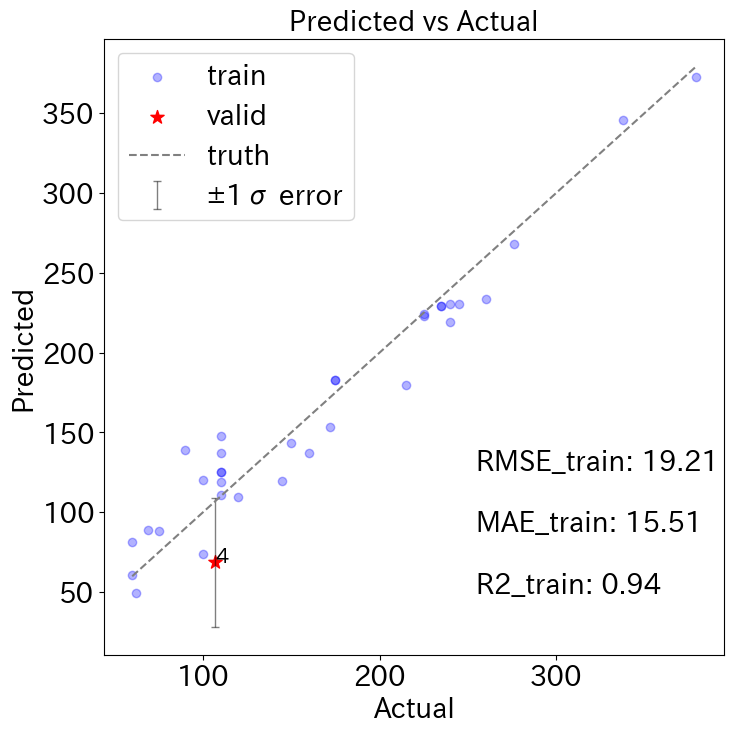

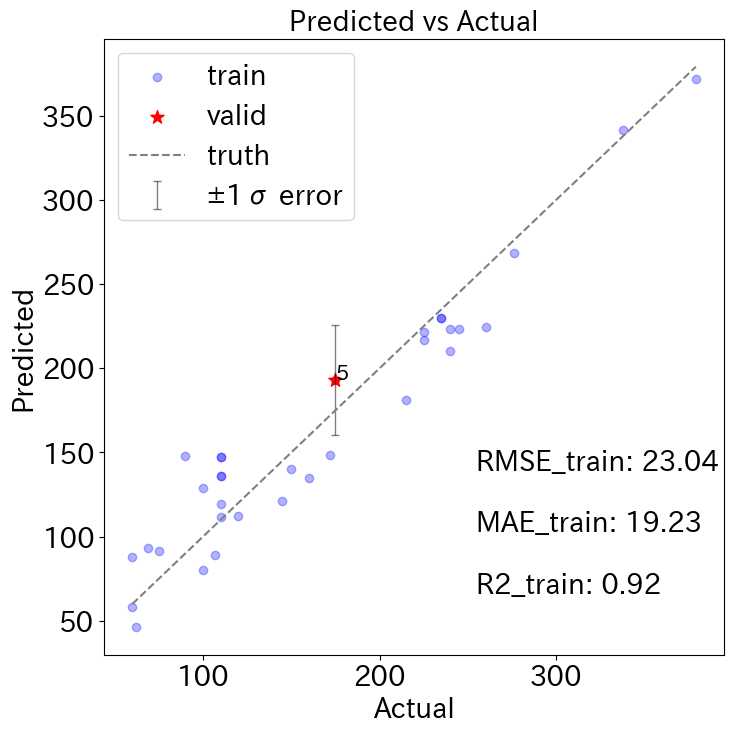

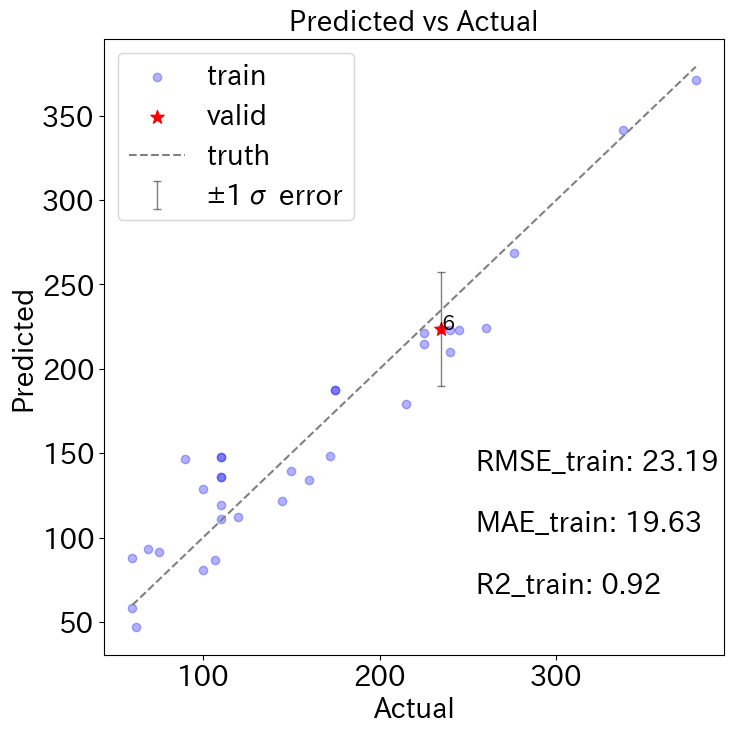

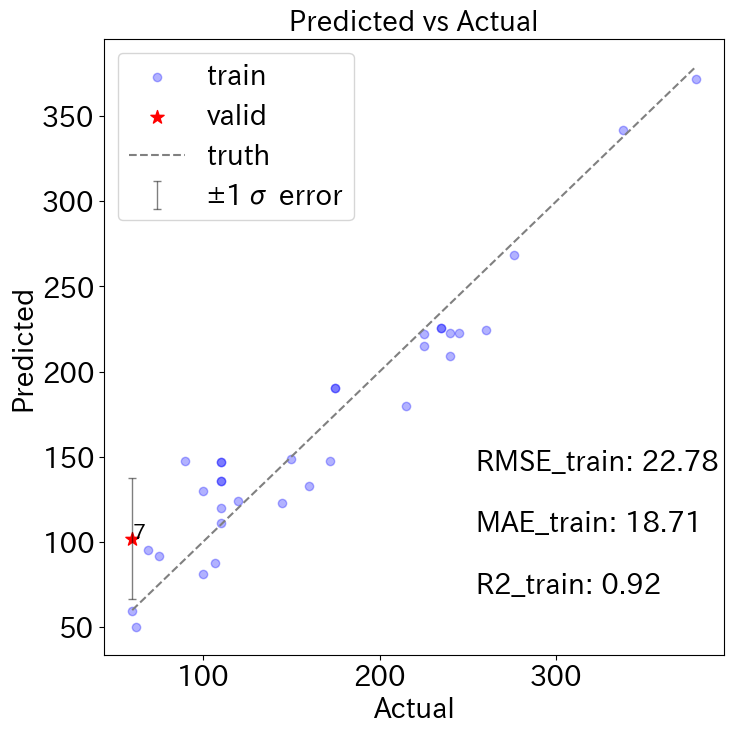

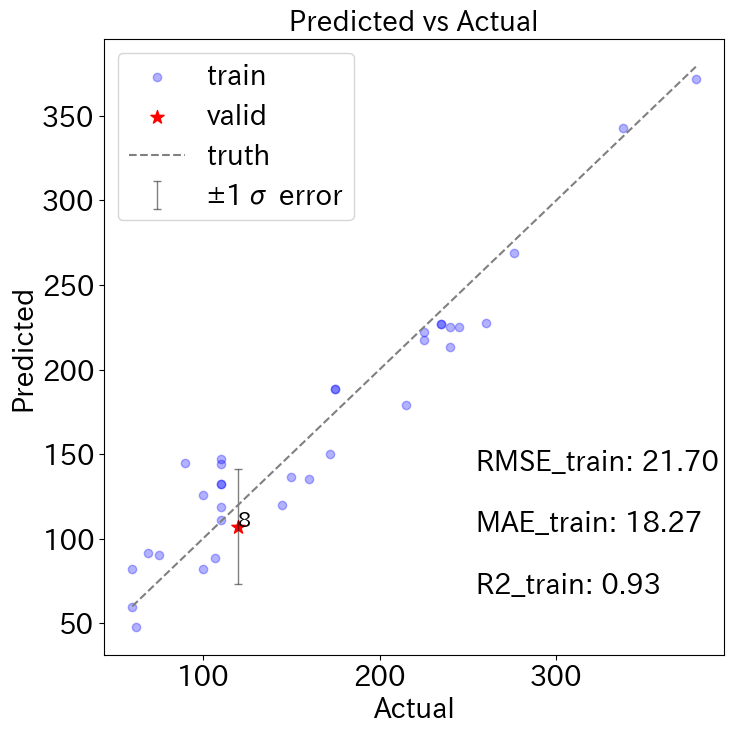

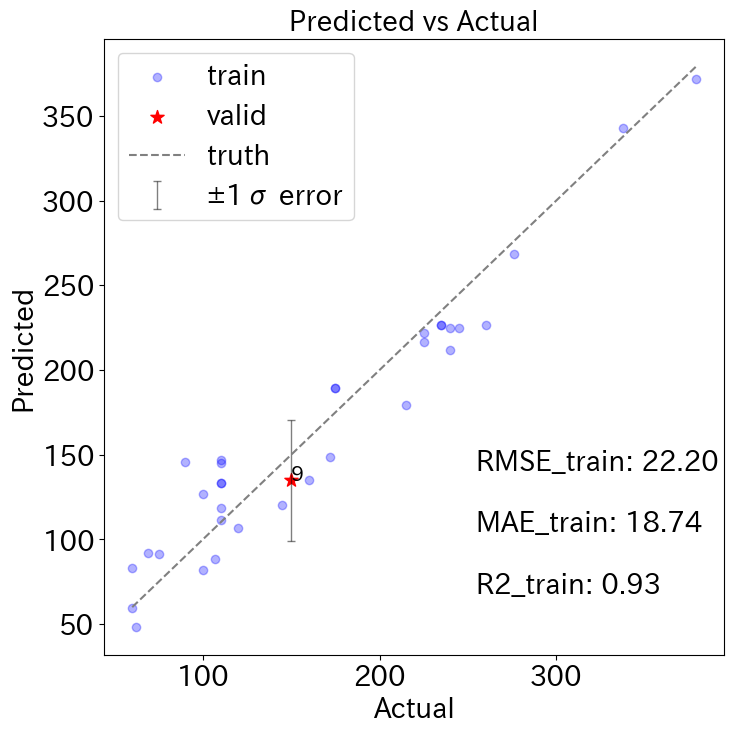

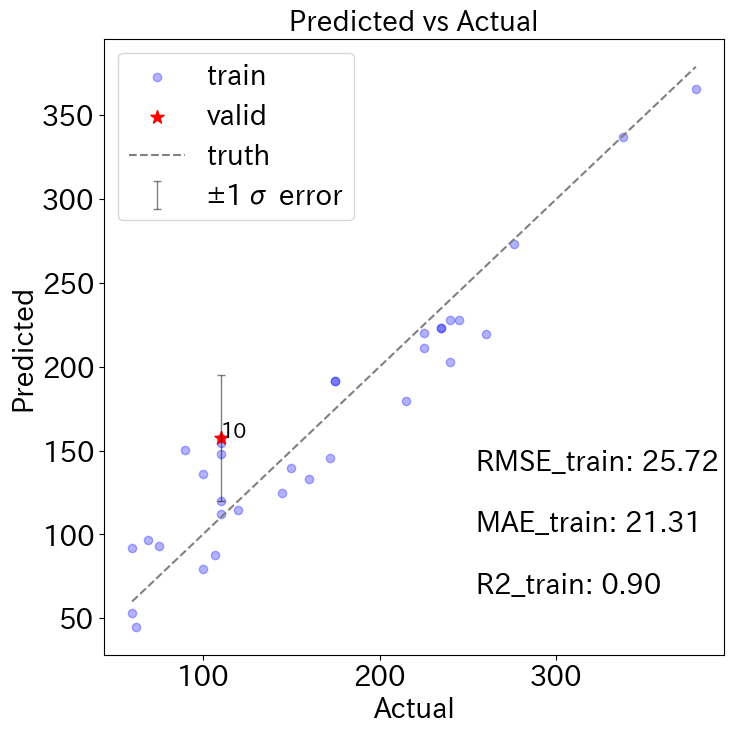

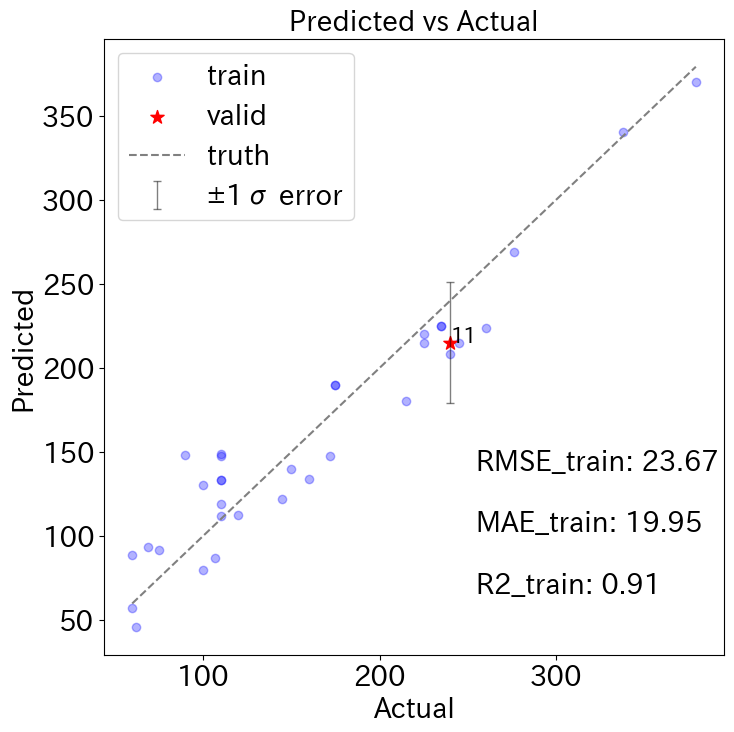

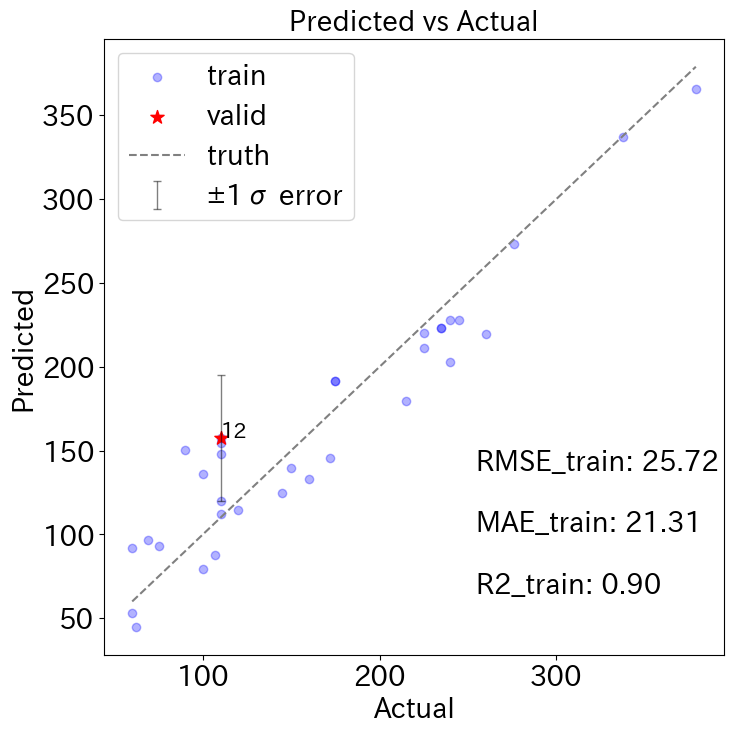

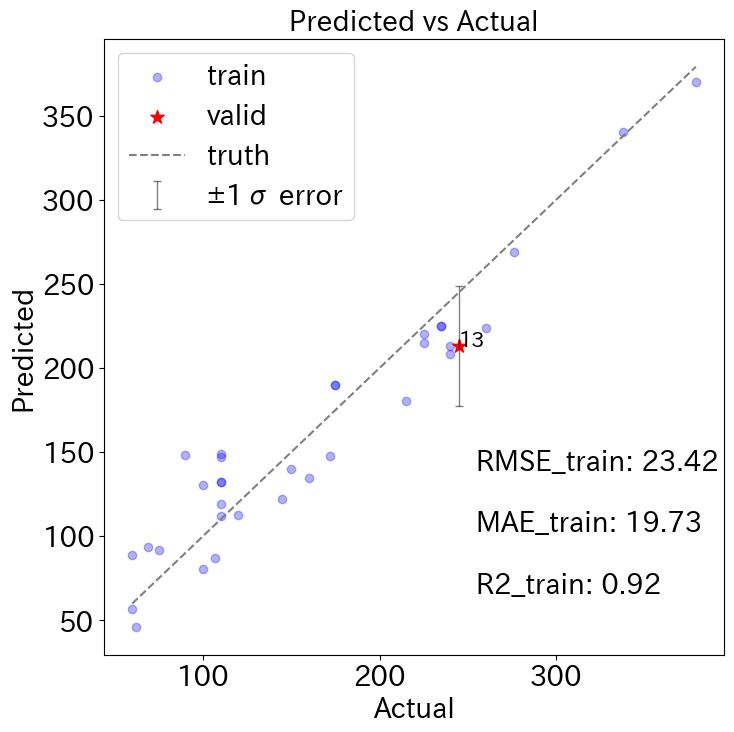

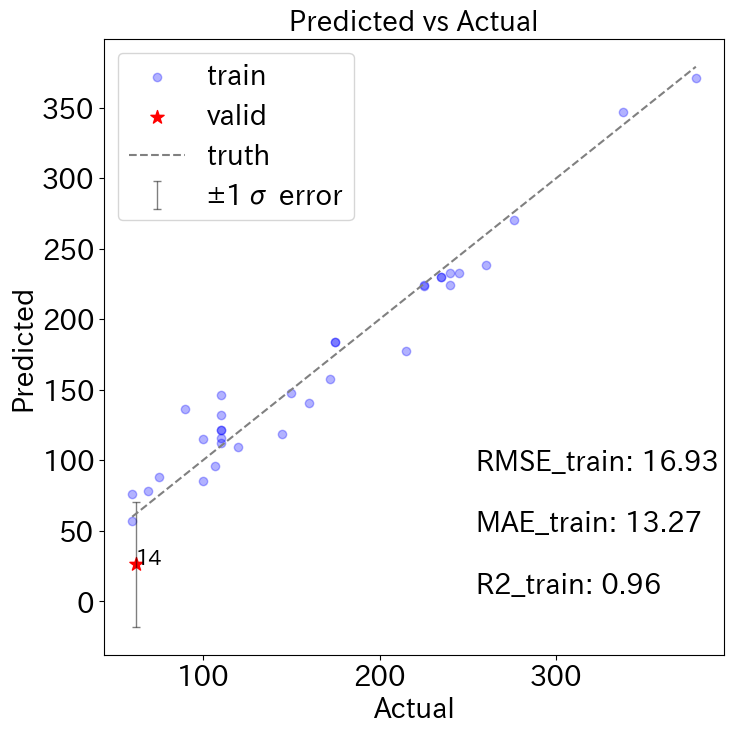

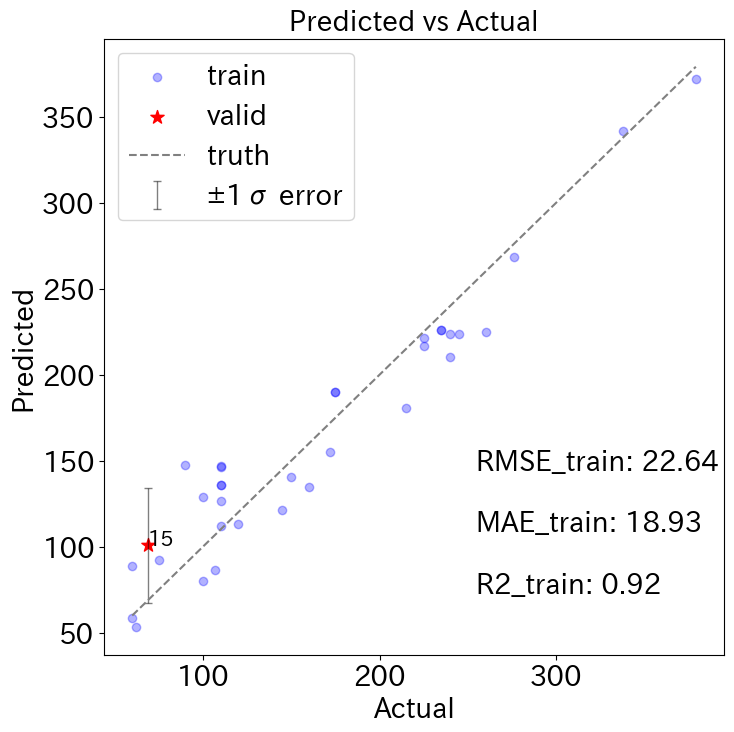

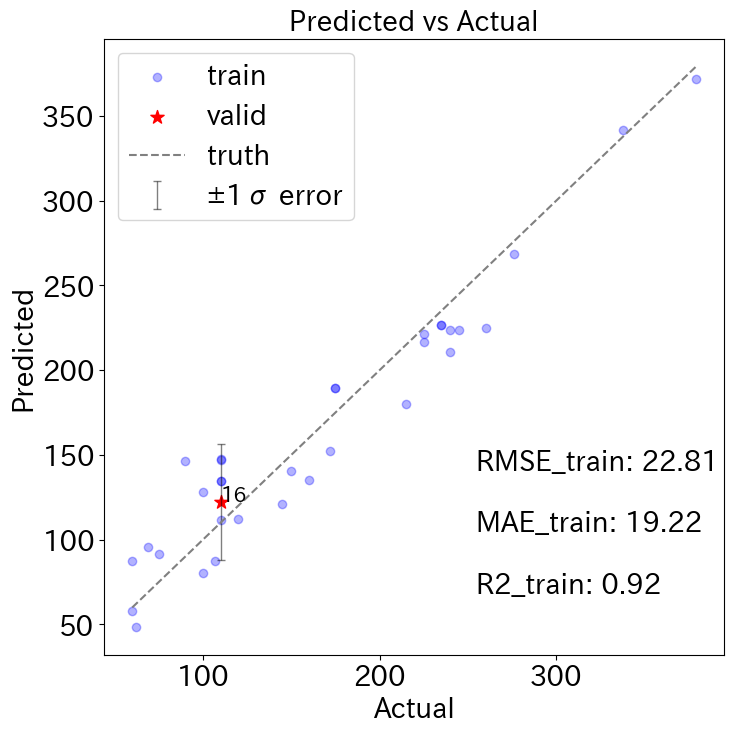

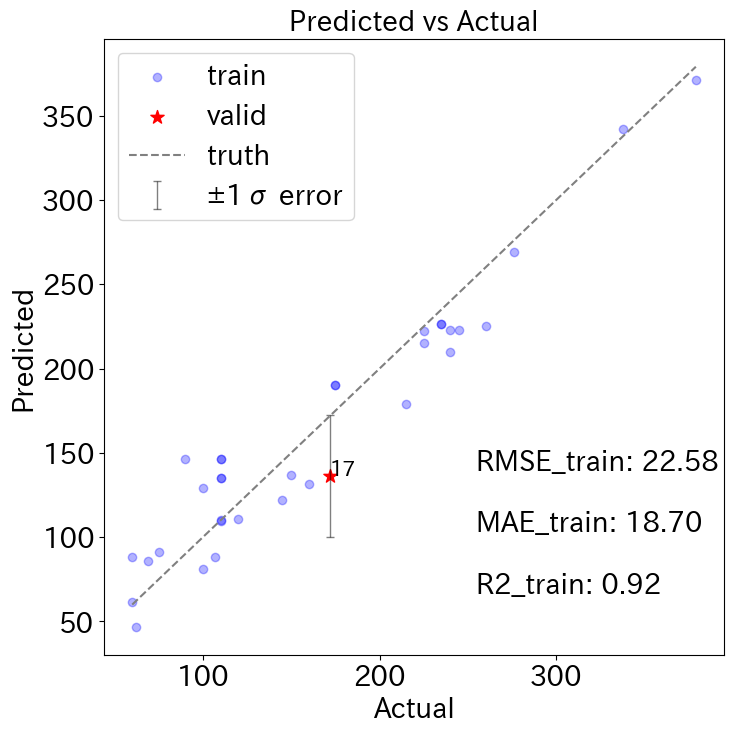

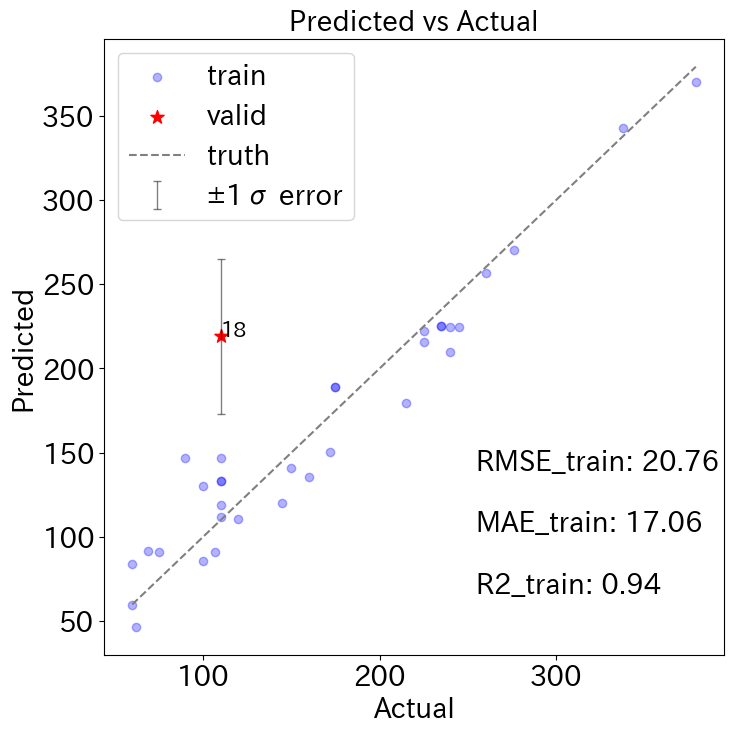

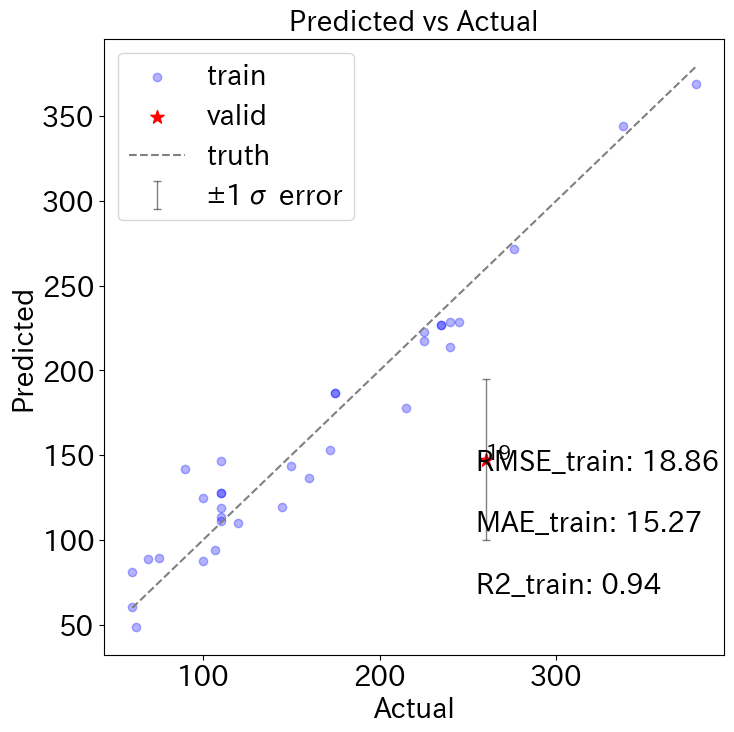

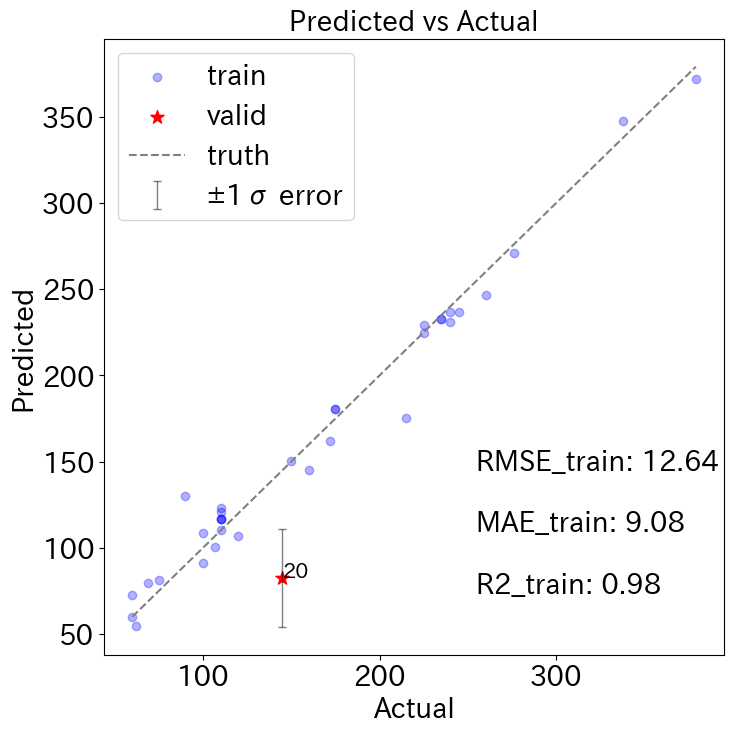

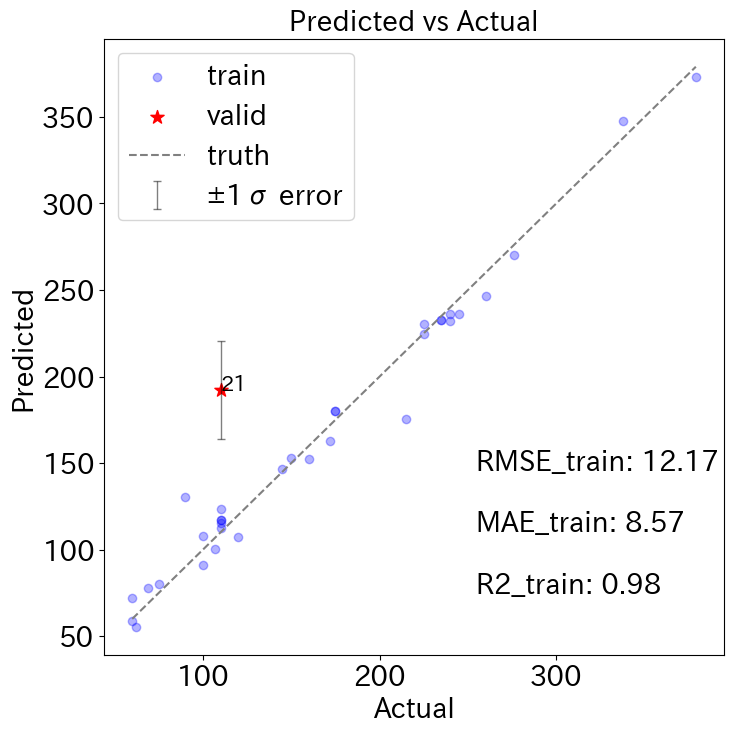

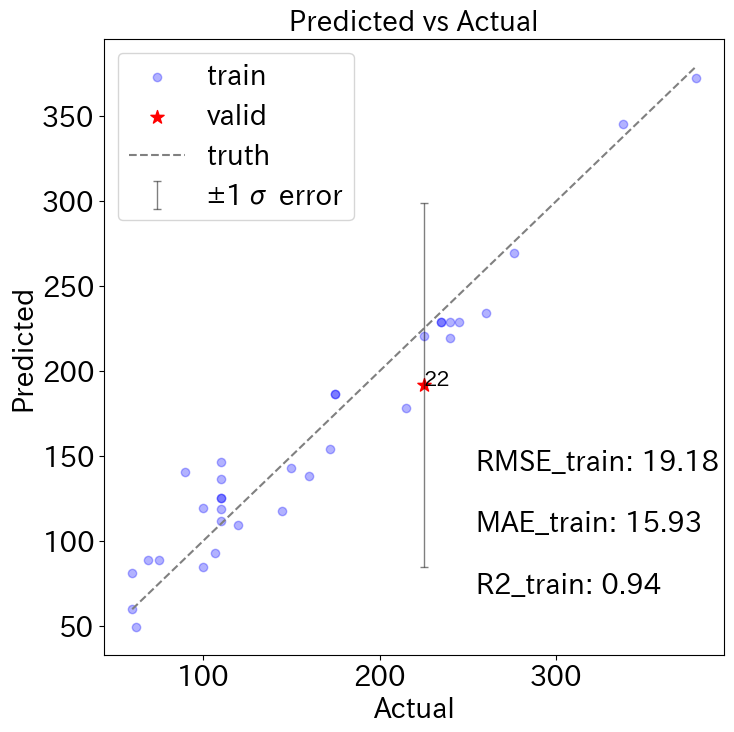

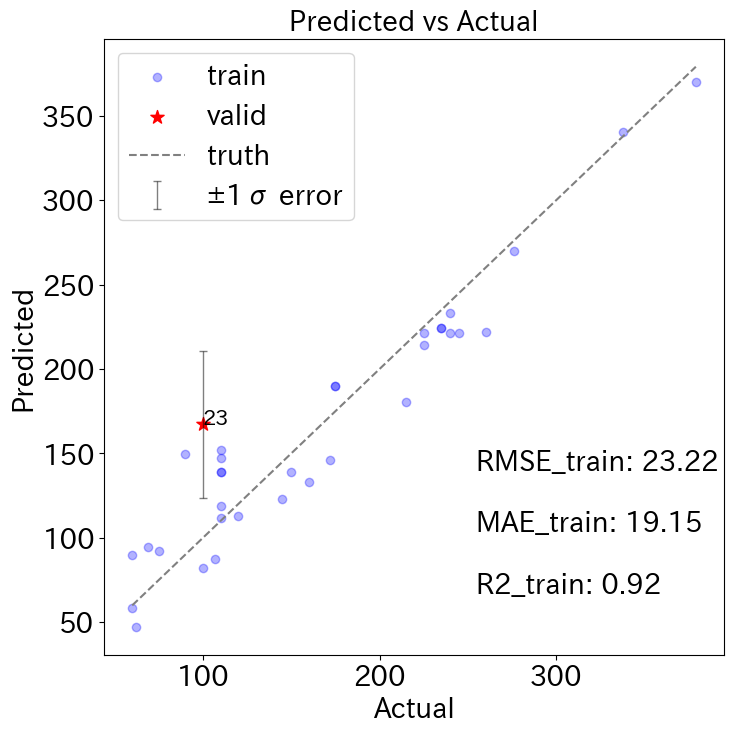

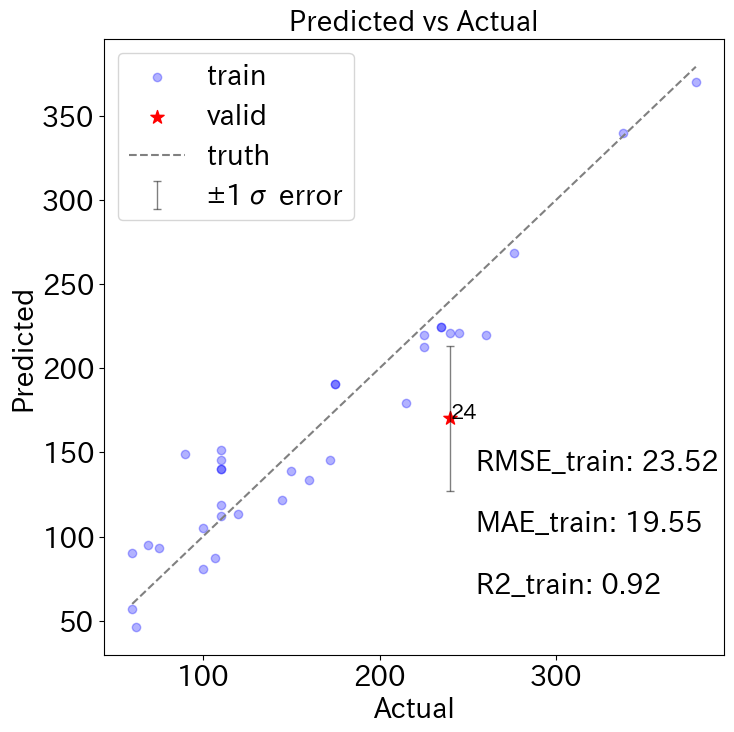

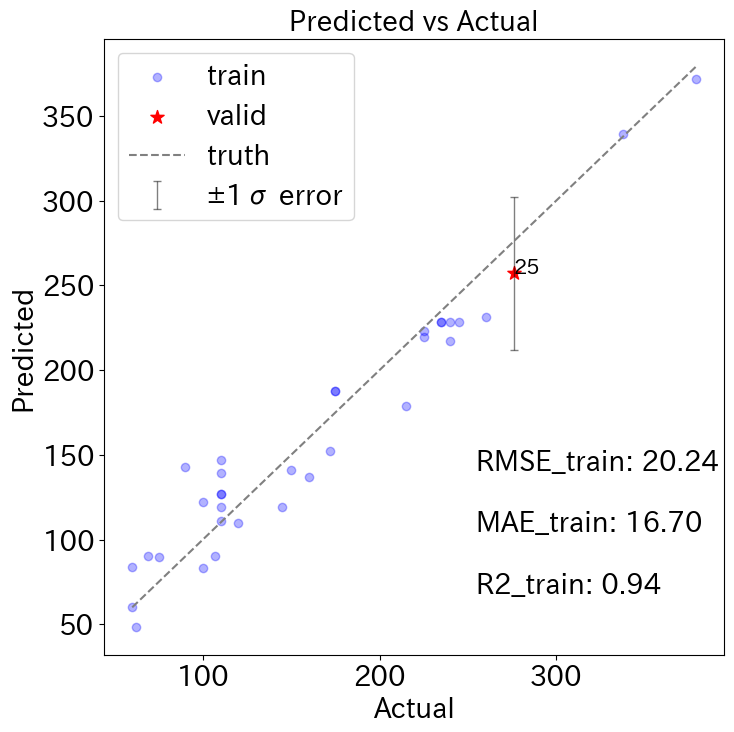

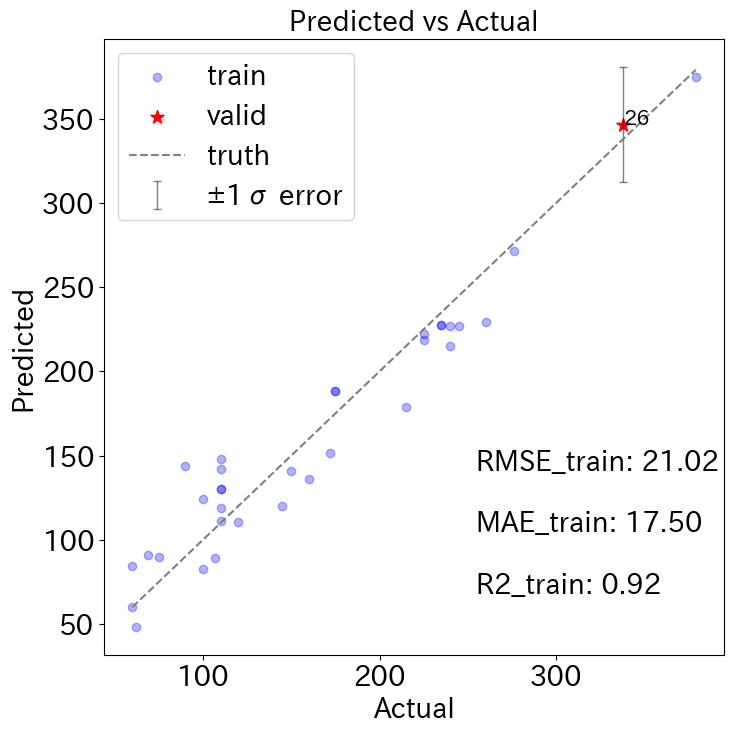

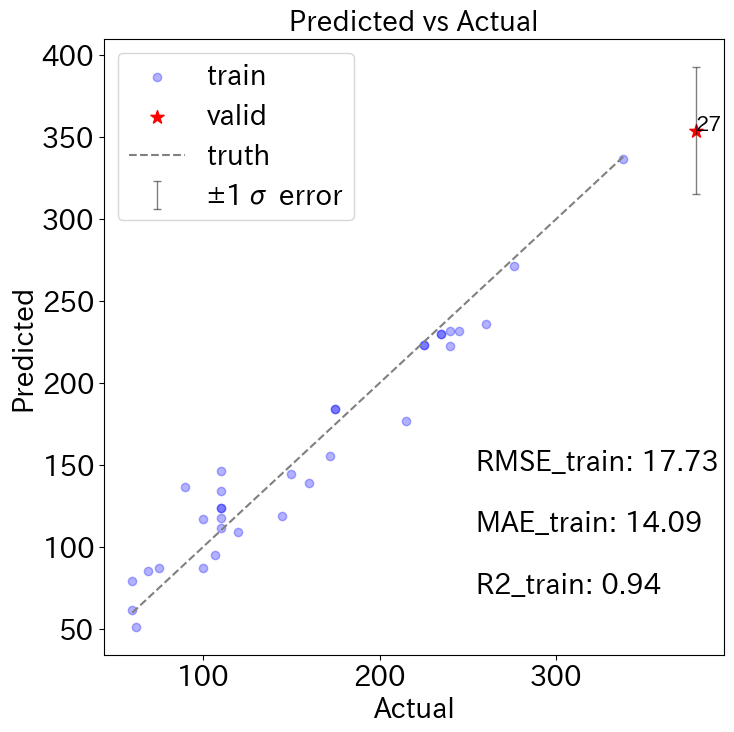

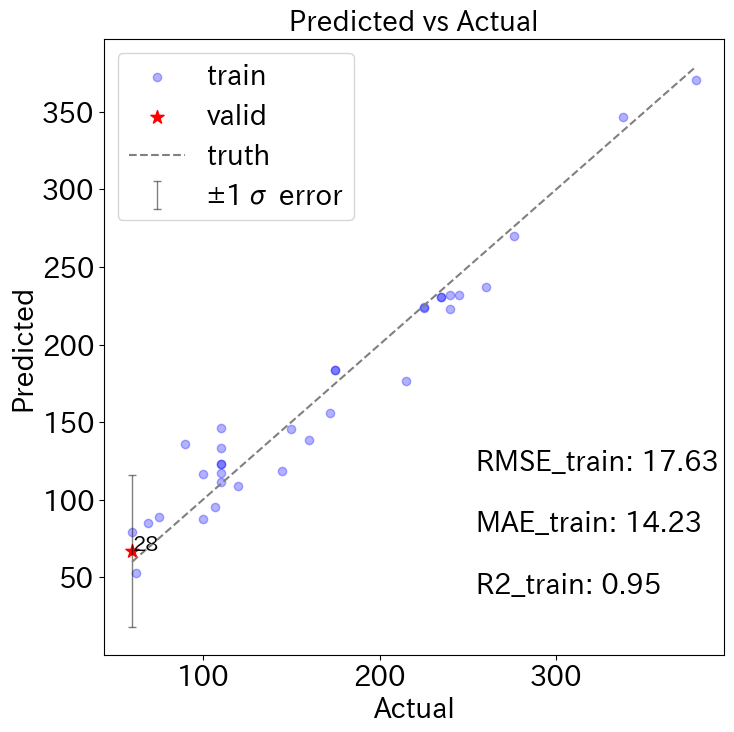

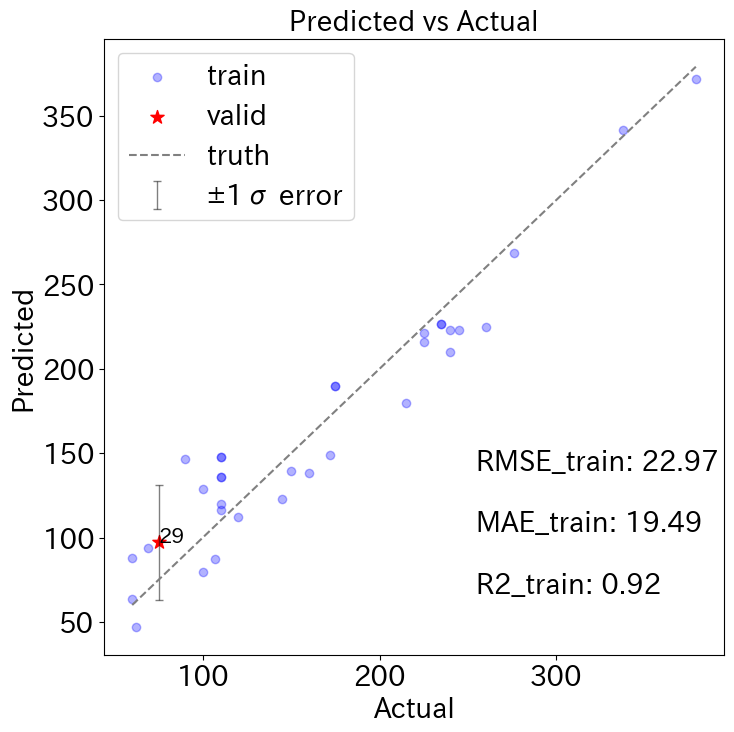

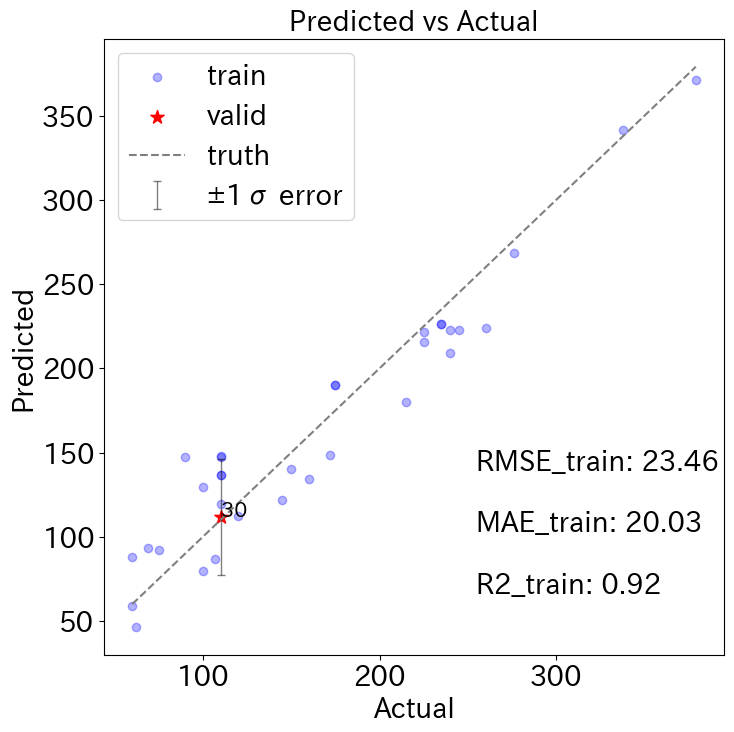

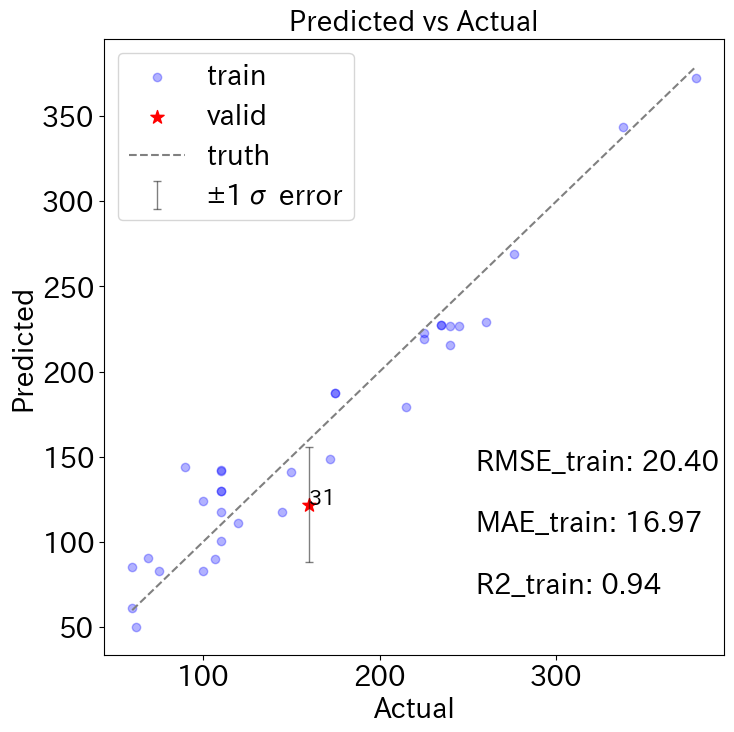

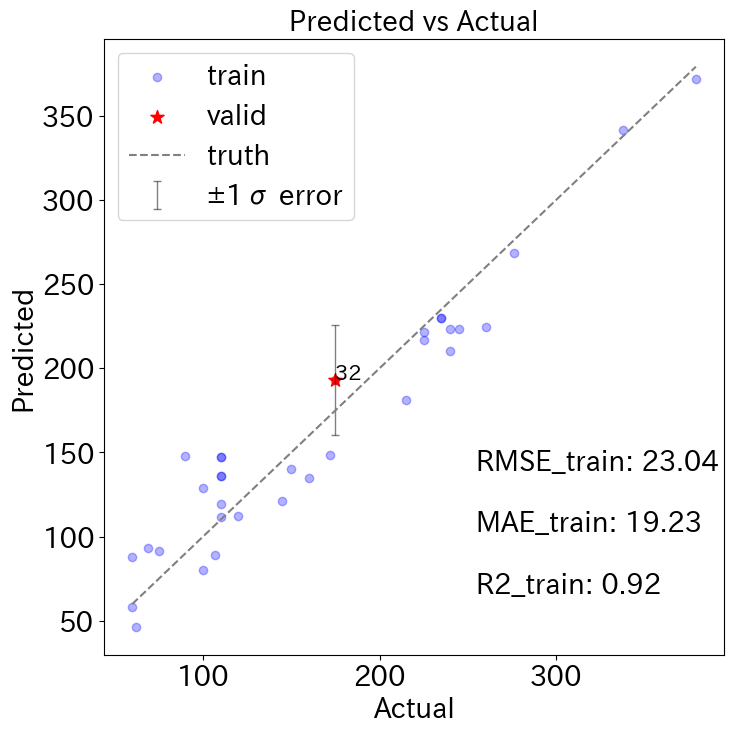

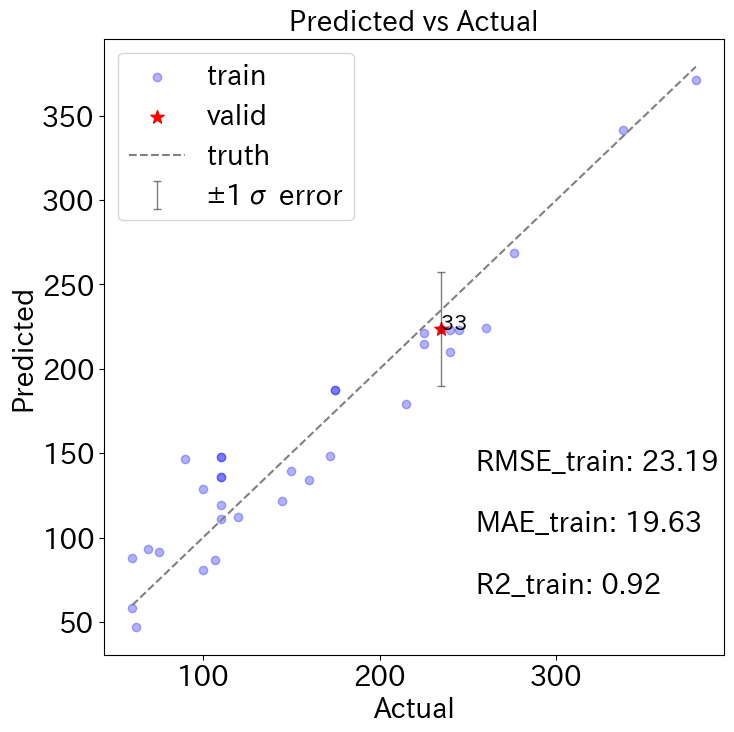

In [36]:
models = []
rmses_train = []
maes_train = []
r2_train = []
rmses_valid = []
maes_valid = []
r2_valid = []
oof = np.zeros(len(train_X))
oof_std = np.zeros(len(train_X))

model = GaussianProcessRegressor(ConstantKernel() * RBF() + WhiteKernel())

folds = len(train_X)
kf = KFold(n_splits=folds)

scaler_x = StandardScaler()
scaler_y = StandardScaler()

for train_index, valid_index in tqdm(kf.split(train_X)):
    X_train = scaler_x.fit_transform(train_X.iloc[train_index])
    X_valid = scaler_x.transform(train_X.iloc[valid_index])
    y_train = scaler_y.fit_transform(train_Y.iloc[train_index].values.reshape(-1, 1))
    y_valid = scaler_y.transform(train_Y.iloc[valid_index].values.reshape(-1, 1))

    model.fit(X_train, y_train)
    y_pred_train = scaler_y.inverse_transform(model.predict(X_train).reshape(-1, 1))
    y_pred_valid_scaled, std_valid_scaled = model.predict(X_valid, return_std=True)
    y_pred_valid = scaler_y.inverse_transform(y_pred_valid_scaled.reshape(-1, 1)).ravel()
    std_valid = std_valid_scaled * scaler_y.scale_[0]

    y_train = scaler_y.inverse_transform(y_train)
    y_valid = scaler_y.inverse_transform(y_valid)

    tmp_rmses_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    tmp_maes_train = mean_absolute_error(y_train, y_pred_train)
    tmp_r2_train = r2_score(y_train, y_pred_train)

    tmp_rmses_valid = np.sqrt(mean_squared_error(y_valid, y_pred_valid))
    tmp_maes_valid = mean_absolute_error(y_valid, y_pred_valid)
    tmp_r2_valid = r2_score(y_valid, y_pred_valid)

    print(train_Y.iloc[valid_index].index)
    print("RMSE_train:", tmp_rmses_train)
    print("MAE_train:", tmp_maes_train)
    print("R2_train:", tmp_r2_train)
    # print("RMSE_valid:", tmp_rmses_valid)
    # print("MAE_valid:", tmp_maes_valid)
    # print("R2_valid:", tmp_r2_valid)

    models.append(model)
    rmses_train.append(np.sqrt(mean_squared_error(y_train, y_pred_train)))
    maes_train.append(mean_absolute_error(y_train, y_pred_train))
    r2_train.append(r2_score(y_train, y_pred_train))
    # rmses_valid.append(np.sqrt(mean_squared_error(y_valid, y_pred_valid)))
    # maes_valid.append(mean_absolute_error(y_valid, y_pred_valid))
    # r2_valid.append(r2_score(y_valid, y_pred_valid))

    oof[valid_index] = y_pred_valid
    oof_std[valid_index] = std_valid

    plt.figure(figsize=(8, 8))
    plt.title("Predicted vs Actual")
    plt.scatter(y_train, y_pred_train, label="train", color="blue", alpha=0.3)
    plt.scatter(y_valid, y_pred_valid, label="valid", color="red", marker="*", s=100)
    x_truth = np.arange(y_train.min(), y_train.max() + 1)
    y_truth = x_truth
    plt.errorbar(y_valid, y_pred_valid, yerr=std_valid, fmt='none', ecolor='black', elinewidth=1, capsize=3, alpha=0.5, label="±1σ error")
    plt.plot(x_truth, y_truth, "--", color="gray", label="truth")
    # plt.textでRMSE, MAE, R2を右下に表示
    plt.text(
        0.6, 0.3, f"RMSE_train: {tmp_rmses_train:.2f}", transform=plt.gca().transAxes
    )
    plt.text(
        0.6, 0.2, f"MAE_train: {tmp_maes_train:.2f}", transform=plt.gca().transAxes
    )
    plt.text(0.6, 0.1, f"R2_train: {tmp_r2_train:.2f}", transform=plt.gca().transAxes)
    # plt.txtでvalid_indexに対応するサンプルIDを表示
    for i, txt in enumerate(data.iloc[valid_index].index):
        plt.text(y_valid[i], y_pred_valid[i], txt, fontsize=15)

    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.legend()

### Out-Of-Fold(OOF)のプロット

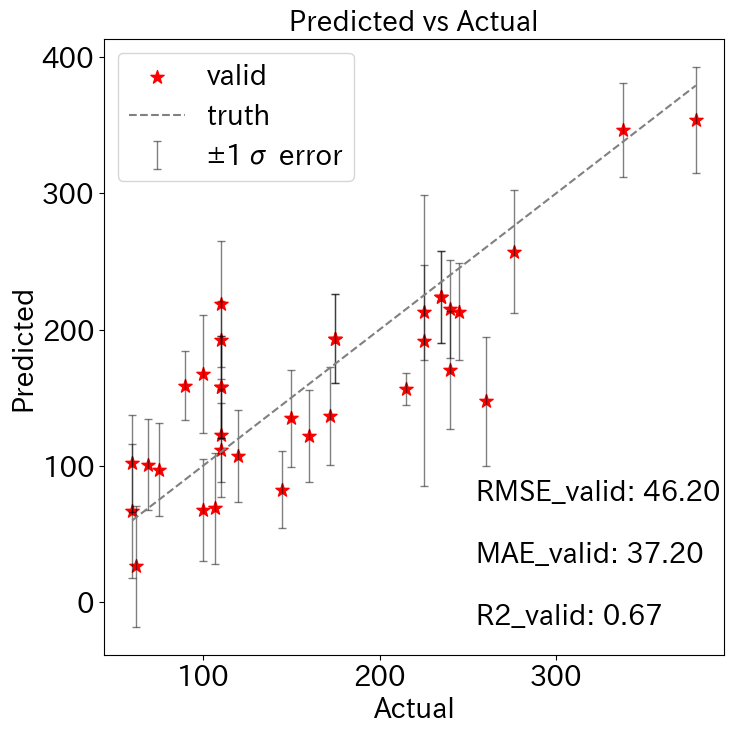

In [37]:
# oofをActualとPredictedに分けてプロット
plt.figure(figsize=(8, 8))
plt.title(f"Predicted vs Actual")
plt.scatter(train_Y, oof, label="valid", color="red", marker="*", s=100)
plt.errorbar(train_Y, oof, yerr=oof_std.ravel(), fmt='none', ecolor='black', elinewidth=1, capsize=3, alpha=0.5, label="±1σ error")
x_truth = np.arange(train_Y.values.min(), train_Y.values.max() + 1)
y_truth = x_truth
plt.plot(x_truth, y_truth, "--", color="gray", label="truth")
plt.xlabel("Actual")
plt.ylabel("Predicted")
# plt.textでRMSE, MAE, R2を右下に表示
plt.text(
    0.6,
    0.25,
    f"RMSE_valid: {np.sqrt(mean_squared_error(train_Y, oof)):.2f}",
    transform=plt.gca().transAxes,
)
plt.text(
    0.6,
    0.15,
    f"MAE_valid: {mean_absolute_error(train_Y, oof):.2f}",
    transform=plt.gca().transAxes,
)
plt.text(
    0.6, 0.05, f"R2_valid: {r2_score(train_Y, oof):.2f}", transform=plt.gca().transAxes
)
plt.legend()

In [70]:
fig.write_html(f"{CFG.output_dir}/scej_mi_chapter12_example_plotly.html")

### Out-Of-Fold(OOF)のプロット&各水準のIDを表示

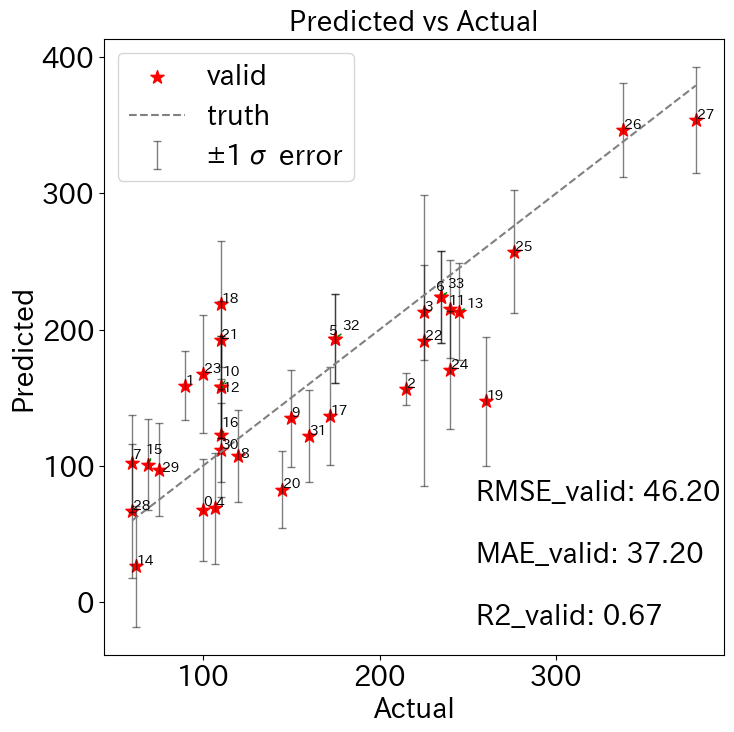

In [38]:
# oofをActualとPredictedに分けてプロット
plt.figure(figsize=(8, 8))
plt.title(f"Predicted vs Actual")
plt.scatter(train_Y, oof, label="valid", color="red", marker="*", s=100)
plt.errorbar(train_Y, oof, yerr=oof_std.ravel(), fmt='none', ecolor='black', elinewidth=1, capsize=3, alpha=0.5, label="±1σ error")
x_truth = np.arange(train_Y.values.min(), train_Y.values.max() + 1)
y_truth = x_truth
plt.plot(x_truth, y_truth, "--", color="gray", label="truth")
plt.xlabel("Actual")
plt.ylabel("Predicted")
# plt.textでRMSE, MAE, R2を右下に表示
plt.text(
    0.6,
    0.25,
    f"RMSE_valid: {np.sqrt(mean_squared_error(train_Y, oof)):.2f}",
    transform=plt.gca().transAxes,
)
plt.text(
    0.6,
    0.15,
    f"MAE_valid: {mean_absolute_error(train_Y, oof):.2f}",
    transform=plt.gca().transAxes,
)
plt.text(
    0.6, 0.05, f"R2_valid: {r2_score(train_Y, oof):.2f}", transform=plt.gca().transAxes
)
# plt.txtでvalid_indexに対応するサンプルIDを表示、adjustTextモジュールを使用して、重なりがないように表示
texts = [
    plt.text(train_Y.values[i], oof[i], data.index[i], fontsize=10)
    for i in range(len(train_Y))
]
adjust_text(texts, arrowprops=dict(arrowstyle="->", color="green"))
plt.legend()

In [49]:
p_1sigma = norm.cdf(1) - norm.cdf(-1) # 正規分布を仮定した際に±1σに予測値が入る確率
p_2sigma = norm.cdf(2) - norm.cdf(-2) # 正規分布を仮定した際に±2σに予測値が入る確率
p_3sigma = norm.cdf(3) - norm.cdf(-3) # 正規分布を仮定した際に±3σに予測値が入る確率

print(f"正規分布を仮定した際に±1σに予測値が入る確率: {p_1sigma*100:.2f}%")
print(f"正規分布を仮定した際に±2σに予測値が入る確率: {p_2sigma*100:.2f}%")
print(f"正規分布を仮定した際に±3σに予測値が入る確率: {p_3sigma*100:.2f}%")

正規分布を仮定した際に±1σに予測値が入る確率: 68.27%
正規分布を仮定した際に±2σに予測値が入る確率: 95.45%
正規分布を仮定した際に±3σに予測値が入る確率: 99.73%


In [55]:
oof_df = pd.DataFrame({'Predicted': oof, 'Actual': data["2% proof stress (Mpa)"].values})
oof_df['Predicted_Std'] = oof_std
oof_df["Sample_No"] = oof_df.index
oof_df

,Predicted,Actual,Predicted_Std,Sample_No
0,67.907142,100,37.374065,0
1,158.833380,90,25.448616,1
2,156.422191,215,11.881513,2
3,212.723676,225,34.841842,3
4,68.851912,107,40.450357,4
5,193.221625,175,32.706946,5
6,223.683448,235,33.795212,6
7,101.864712,60,35.619276,7
8,107.158282,120,33.753732,8
9,134.770639,150,35.777033,9


In [69]:
fig = px.scatter(
    oof_df,
    x="Actual",
    y="Predicted",
    hover_data=["Sample_No", "Predicted_Std"]
)

max_val = max(oof_df["Actual"].max(), oof_df["Predicted"].max())
max_val = np.ceil(max_val * 1.1)

fig.add_trace(go.Scatter(
    x=[0, max_val],
    y=[0, max_val],
    mode='lines',
    line=dict(dash='dash', color='gray'),
    name='y = x'
))

fig.update_layout(
    xaxis_title="Actual",
    yaxis_title="Predicted",
    width=800,
    height=800,
    showlegend=True
)
fig.update_xaxes(range=[0, max_val])
fig.update_yaxes(range=[0, max_val], scaleanchor="x", scaleratio=1)

fig.show()

In [39]:
# 簡単のためにモデルを1つで議論するため、Fulltrainモデルを準備
X_train_all = scaler_x.fit_transform(train_X)
y_train_all = scaler_y.fit_transform(train_Y.values.reshape(-1, 1))

model_all = GaussianProcessRegressor(ConstantKernel() * RBF() + WhiteKernel())
model_all.fit(X_train_all, y_train_all)

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1))

In [40]:
background = X_train
explainer = shap.KernelExplainer(model_all.predict, background)
shap_values = explainer.shap_values(X_train_all)
shap_values

  0%|          | 0/34 [00:00<?, ?it/s]

array([[-1.24480837e+00,  7.16789528e-02,  6.78552988e-02,
        -1.38926532e-03, -2.18052059e-02,  8.47828260e-02,
        -8.81303904e-03, -7.11604317e-04,  6.37686934e-02,
         8.17996548e-04],
       [-5.20386460e-01,  4.93690724e-02,  8.34146502e-02,
         2.81759797e-02, -1.66368173e-02,  1.60748180e-02,
         2.55227513e-03,  7.98779267e-03,  6.17578057e-02,
         1.36716390e-02],
       [-8.07766154e-02,  4.21978995e-02,  9.04228030e-02,
         4.13810359e-02, -1.17462140e-02, -1.01260960e-02,
         9.89922412e-03,  1.39286291e-02,  6.26728835e-02,
         2.11914331e-02],
       [ 4.10621515e-01,  3.58815151e-02,  9.75789948e-02,
         5.48385805e-02, -5.79841202e-03, -3.52712538e-02,
         1.82535003e-02,  2.07529361e-02,  6.43190187e-02,
         2.95349502e-02],
       [-1.25424868e+00,  7.33934455e-02,  6.75150247e-02,
        -9.05141177e-03, -1.57103012e-02,  6.14363993e-02,
        -7.78947519e-03,  3.36457578e-02,  5.52757313e-02,
         9.

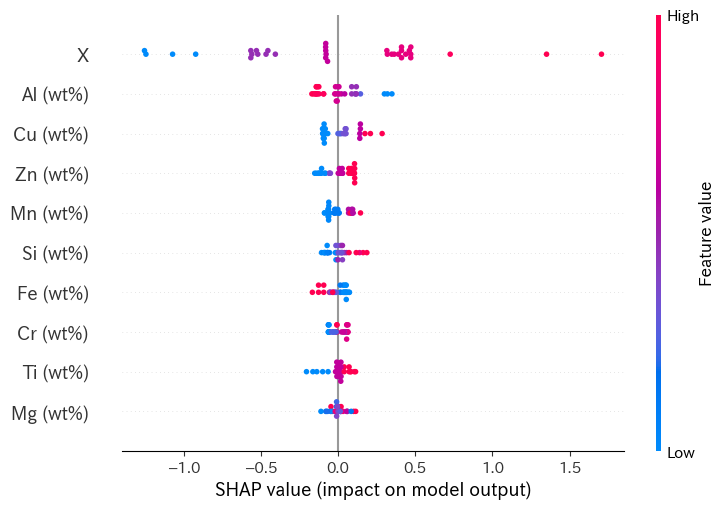

In [41]:
shap.summary_plot(shap_values, X_train_all, feature_names=numeric_parameter_cols)

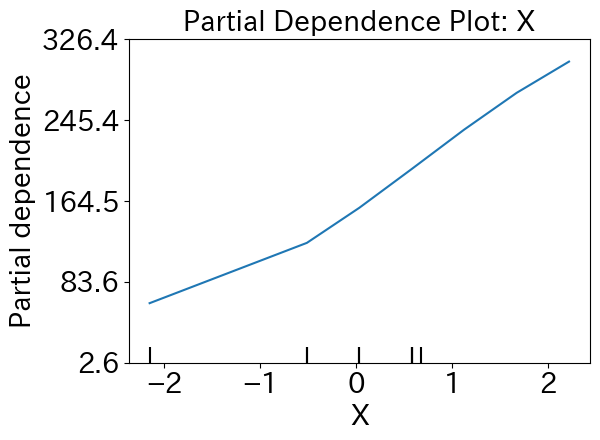

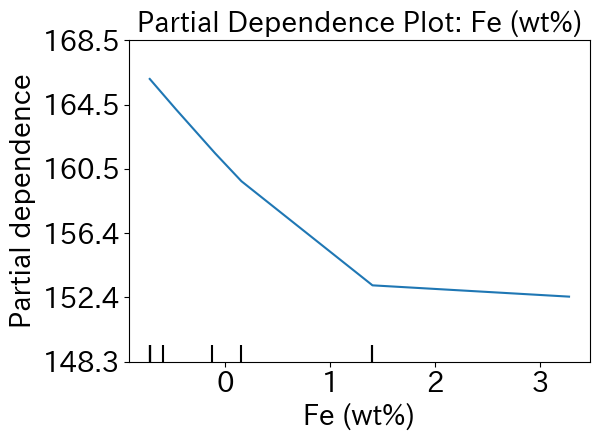

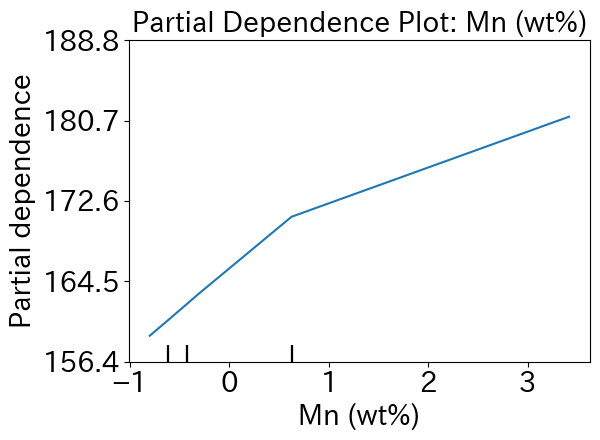

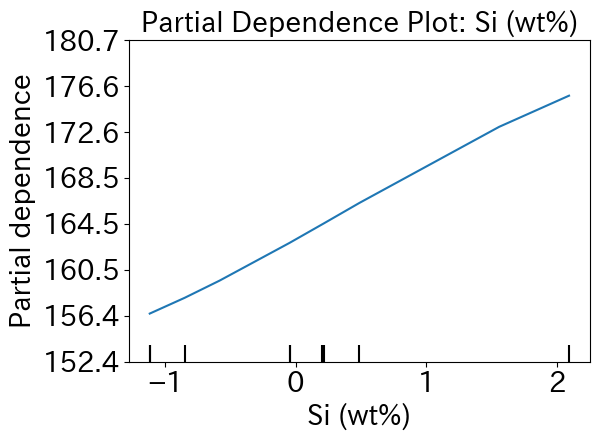

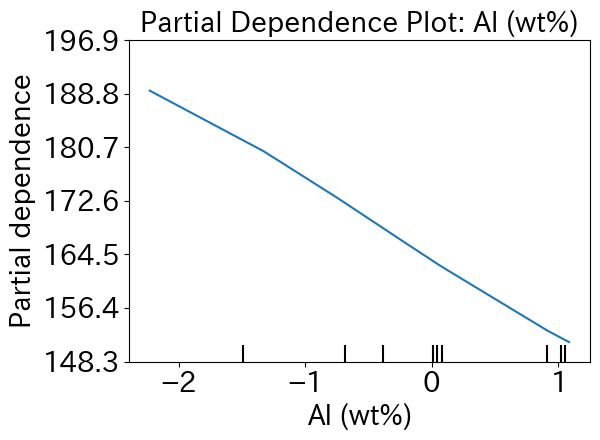

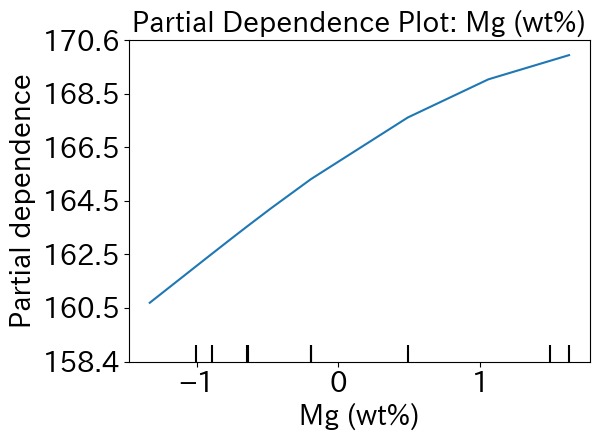

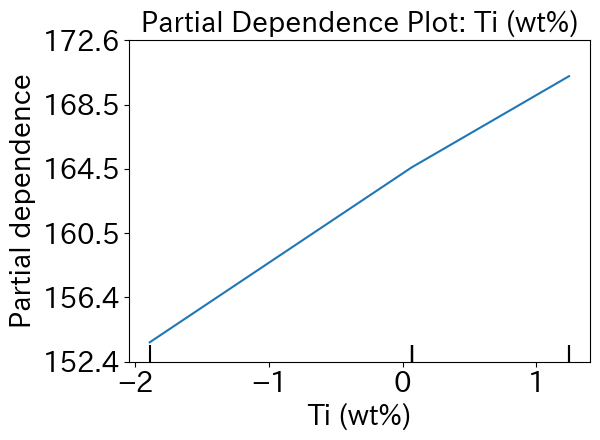

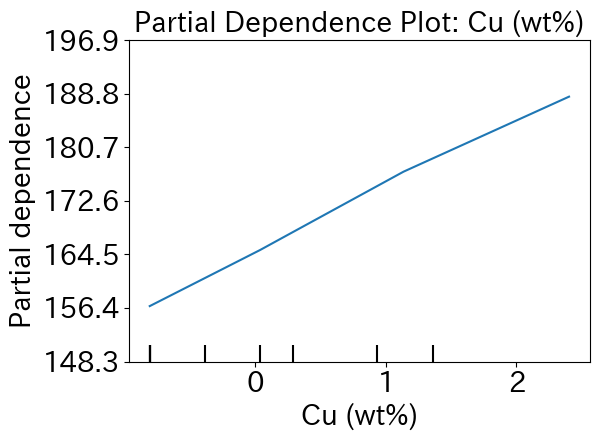

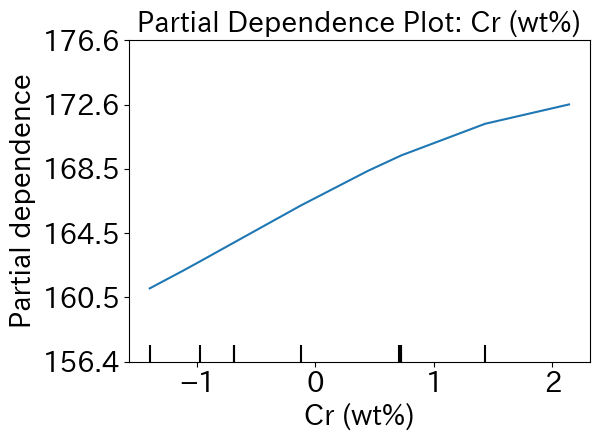

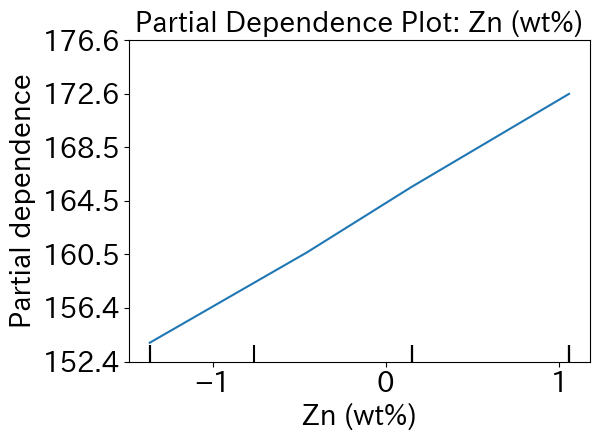

In [42]:
for feature_name in numeric_parameter_cols:
    display = PartialDependenceDisplay.from_estimator(
        estimator=model_all,
        X=X_train_all,
        features=[feature_name],
        feature_names=numeric_parameter_cols,
        kind='average'
    )

    for ax in display.axes_.ravel():
        y_ticks = ax.get_yticks()
        y_ticks_orig = scaler_y.inverse_transform(y_ticks.reshape(-1, 1)).ravel()
        ax.set_yticks(y_ticks)
        ax.set_yticklabels([f"{yt:.1f}" for yt in y_ticks_orig])

    plt.title(f"Partial Dependence Plot: {feature_name}")
    plt.tight_layout()
    plt.show()

### 実行環境の確認及び保存

In [43]:
!python3 -V

Python 3.11.13


In [71]:
!pip freeze > requirements_gp_shap_pdp_plotly.txt

In [72]:
from google.colab import files

files.download('requirements_gp_shap_pdp_plotly.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>